# WOA data

Temperature and nitrate climatologies from

[https://www.nodc.noaa.gov/OC5/woa18/woa18data.html](https://www.nodc.noaa.gov/OC5/woa18/woa18data.html)

***

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs
import calendar

%matplotlib inline

***

Paths and definitions

In [2]:
# Increase plotting font size
plt.rcParams['font.size'] = 12

# Base URL
url = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/'

# Months
months = range(1, 13)

# Define variable fields
fields = [
    ['temperature', 'nitrate'],            # name
    ['$^{\\circ}$C', '$\mu$M/kg'],         # units
    ['decav', 'all'],                      # url string
    [np.arange(0, 21), np.arange(0, 31)],  # contour lims
]

# Populate variables dict list
variables = []
for var, units, urlstr, levels in zip(*fields):
    variables.append({
        'name': var,
        'units': units,
        'urlstr': urlstr,
        'levels': levels,
        'locations': [
            {'name': 'NP subpolar gyre', 'yx': (140,  29)},
            {'name': 'NA subpolar gyre', 'yx': (150, 150)},
            {'name': 'NEP coast'       , 'yx': (130,  54)},
            {'name': 'NEA coast'       , 'yx': (133, 170)},
        ]
    })

***

Local functions

In [3]:
def load_data(var):
    """
    """
    
    # Make plot area with LCC projection
    xmap, ymap = [-135, -15], [20, 60]
    fig, axs = plt.subplots(
        4, 3, figsize=(17, 10), gridspec_kw={'wspace': 0.05, 'hspace': 0.1},
        subplot_kw={'projection': crs.LambertConformal(np.mean(xmap), np.mean(ymap))},
    )
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    axs = axs.flatten()

    # Loop through panels/months
    for ax, month in zip(axs, months):

        # Plot coastlines and formatting
        ax.set_extent(xmap + ymap)
        ax.gridlines()
        ax.coastlines(resolution='50m')
        ax.set_title(calendar.month_name[month])

        # Load monthly average
        path = url + '{}/{}/1.00/woa18_{}_{}{:02d}_01.nc'.format(
            var['name'], var['urlstr'], var['urlstr'], var['name'][0], month,
        )
        with xr.open_dataset(path, decode_times=False) as data:
            
            # Extract depth index
            if 'depth' not in var: var['depth'] = data.depth.values
            
            # Plot monthly average
            c = ax.contourf(
                data.lon, data.lat, data[var['name'][0] + '_an'][0, 0, ...],
                cmap='Greys', levels=var['levels'], extend='max', transform=crs.PlateCarree(),
            )
            
            # Loop through stations
            for loc in var['locations']:
                
                # Extract monthly profile
                if 'data' not in loc: loc['data'] = np.empty((0, len(data.depth)))
                loc['data'] = np.concatenate((
                    loc['data'], data[var['name'][0] + '_an'][(0, slice(None)) + loc['yx']].values[np.newaxis, :],
                ))
                
                # Plot station
                ax.plot(
                    data.lon[loc['yx'][1]], data.lat[loc['yx'][0]],
                    'ro', fillstyle='none', markersize=10, transform=crs.PlateCarree(),
                )

    # Add colobar
    fig.colorbar(c, cax=cax, label='Surface {} [{}]'.format(var['name'], var['units']))

    return fig, ax

In [15]:
def plot_seasonal(var):
    """
    """
    
    # Make plot area
    fig, axs = plt.subplots(2, 2, figsize=(17, 10))
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    axs = axs.flatten()

    # Loop through locations
    for ax, loc in zip(axs, var['locations']):
        c = ax.contourf(months, var['depth'], loc['data'].T, levels=var['levels'], cmap='Greys', extend='max')
        ax.set_ylim([500, 0])
        ax.set_ylabel('Depth [m]')
        ax.set_title(loc['name'])
        ax.xaxis.set_ticks(months)
        ax.xaxis.set_ticklabels([calendar.month_name[month][0] for month in months])

    # Add colobar
    fig.colorbar(c, cax=cax, label='Surface {} [{}]'.format(var['name'], var['units']))
    
    return fig, ax

***

## Temperature climatologies

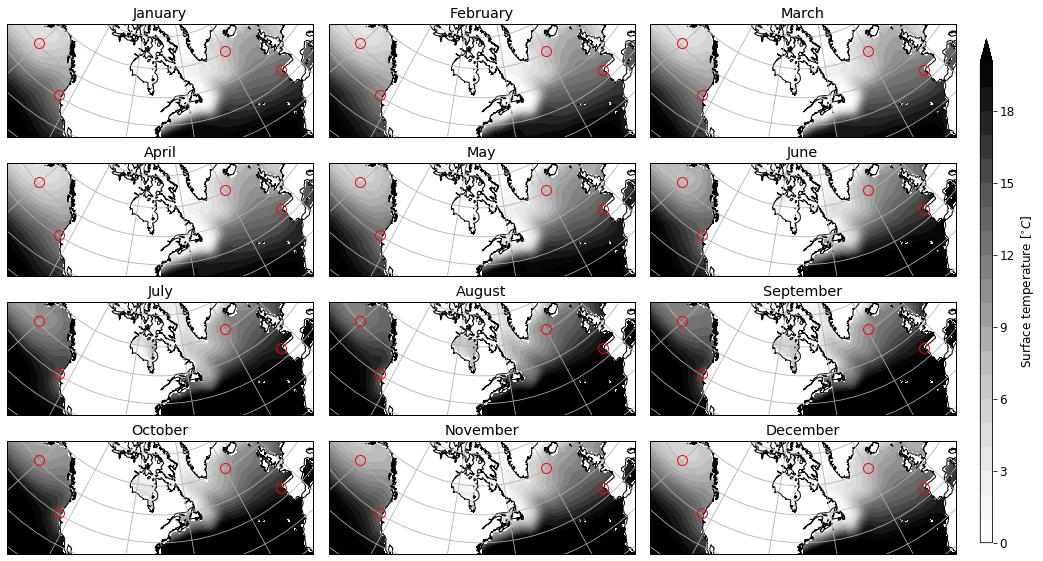

In [4]:
# Extract data and plot surface fields
fig, ax = load_data(variables[0])

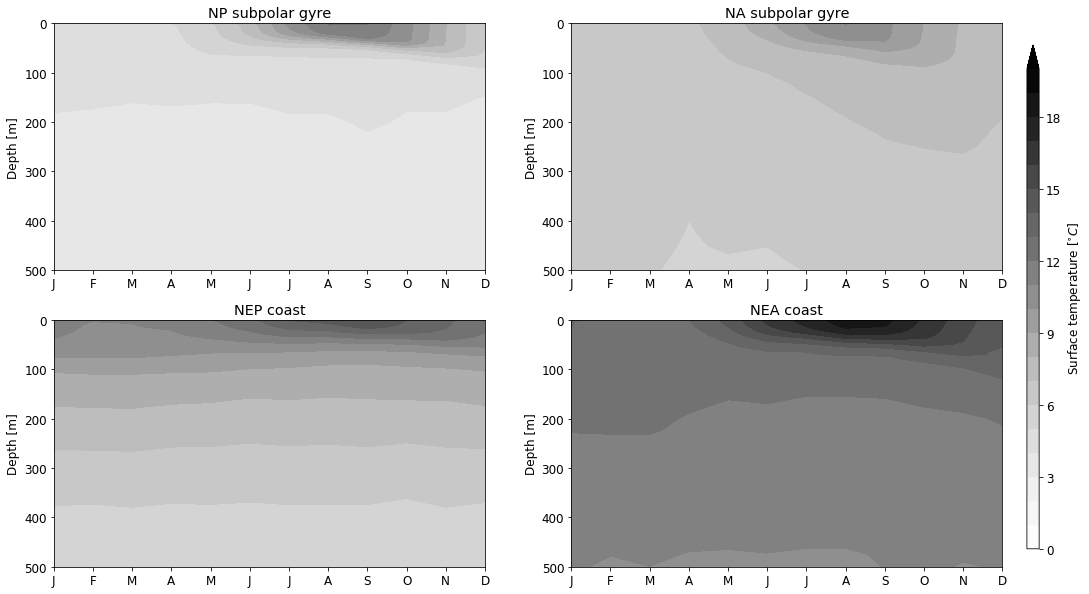

In [16]:
# Plot seasonal cycles
fig, ax = plot_seasonal(variables[0])

***

## Nitrate climatologies

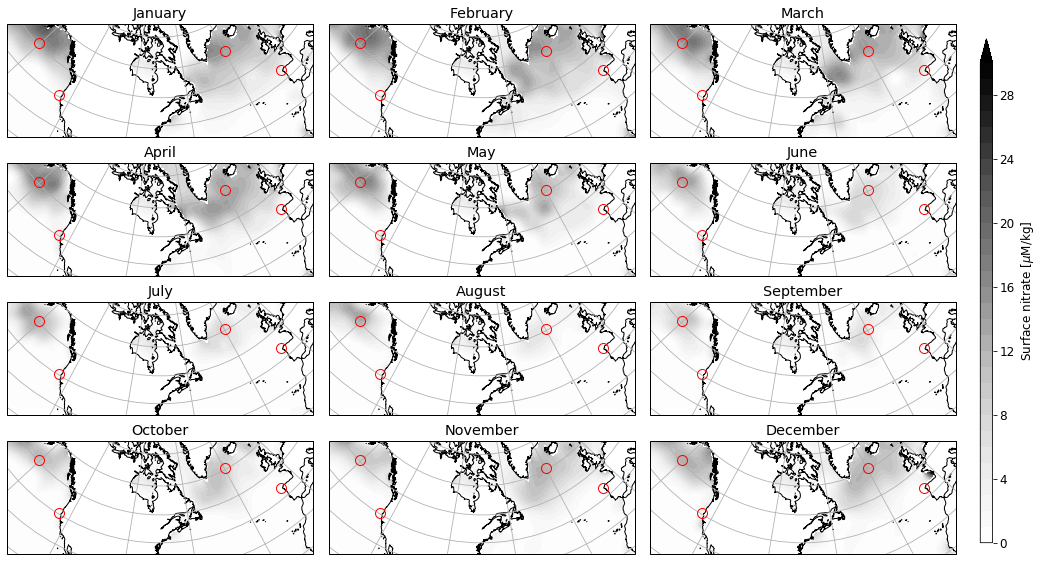

In [17]:
# Extract data and plot surface fields
fig, ax = load_data(variables[1])

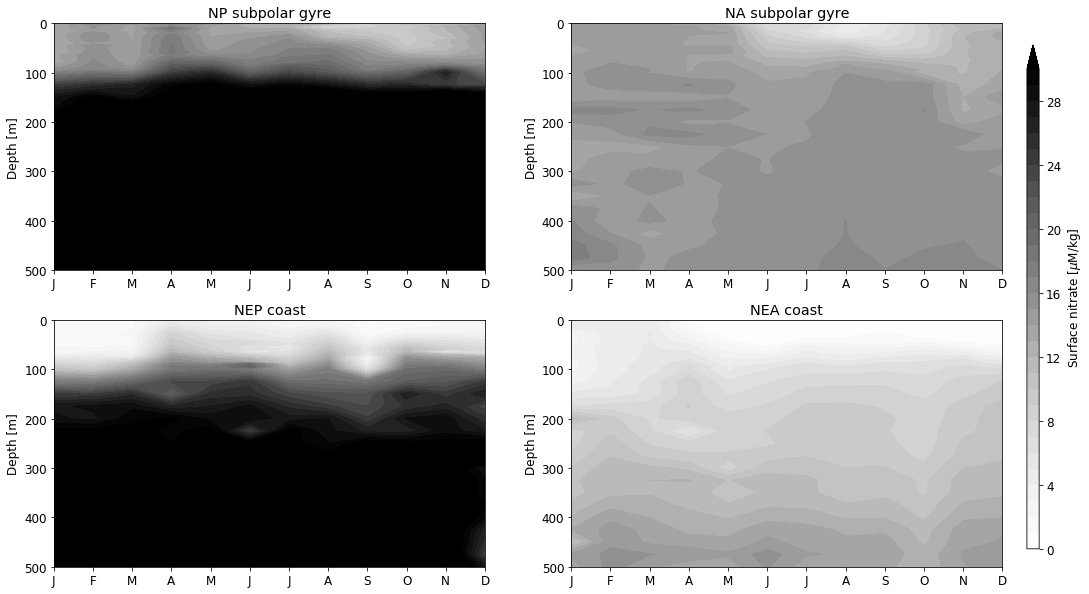

In [18]:
# Plot seasonal cycles
fig, ax = plot_seasonal(variables[1])